In [1849]:
import math
import numpy as np
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [1850]:
def f(x):
    return 3*x**2-4*x+5

In [1851]:
f(3.0)

20.0

In [1852]:
xs=np.arange(-5,5,0.25)

In [1853]:
xs

array([-5.  , -4.75, -4.5 , -4.25, -4.  , -3.75, -3.5 , -3.25, -3.  ,
       -2.75, -2.5 , -2.25, -2.  , -1.75, -1.5 , -1.25, -1.  , -0.75,
       -0.5 , -0.25,  0.  ,  0.25,  0.5 ,  0.75,  1.  ,  1.25,  1.5 ,
        1.75,  2.  ,  2.25,  2.5 ,  2.75,  3.  ,  3.25,  3.5 ,  3.75,
        4.  ,  4.25,  4.5 ,  4.75])

In [1854]:
ys=f(xs)

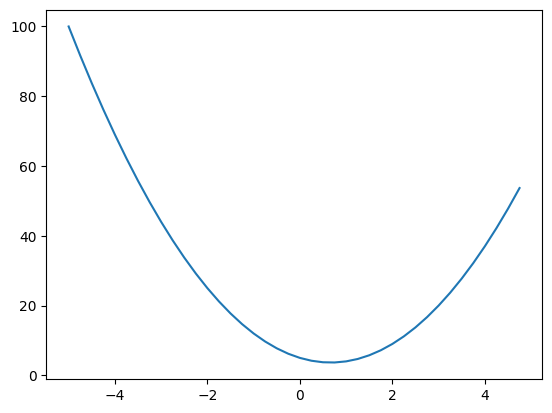

In [1855]:
plt.plot(xs,ys)

In [1856]:
#explanation of multivariable derivatives
x=2/3
h=0.000000001
(f(x+h)-f(x))/h

0.0

In [1857]:
#lets get more complex here 
a=4.0
b=2.0
c=1.0
d=a*b+c
d

9.0

In [1858]:
#explanation of multivariable derivatives
h=0.0000001
a=4.0
b=2.0
c=1.0
d1=a*b+c
c+=h
d2=a*b+c
print('d1',d1)
print('d2',d2)
print('slope',(d2-d1)/h)

d1 9.0
d2 9.0000001
slope 0.999999993922529


In [1859]:
class Value:
  
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')
    
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    
    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')
    
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
      
    return out
  
  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out
  
  def __rmul__(self, other): # other * self
    return self * other

  def __truediv__(self, other): # self / other
    return self * other**-1

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)

  def __radd__(self, other): # other + self
    return self + other

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    
    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    
    return out
  
  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')
    
    def _backward():
      self.grad += out.data * out.grad # NOTE: in the video I incorrectly used = instead of +=. Fixed here.
    out._backward = _backward
    
    return out
  
  
  def backward(self):
    
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()



In [1860]:
a=Value(2.0,label='a')
a

Value(data=2.0)

In [1861]:
b=Value(3.0,label='b')
b

Value(data=3.0)

In [1862]:
a+b
a.__add__(b)

Value(data=5.0)

In [1863]:
c=a*b

In [1864]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L

Value(data=-8.0)

In [1865]:
L._prev

{Value(data=-2.0), Value(data=4.0)}

In [1866]:
L._op

'*'

In [1867]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})

    nodes, edges = trace(root)
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    for n in nodes:
        uid = str(id(n))
        dot.node(name=uid, label="{%s | data %.4f | grad %0.4f}" % (n.label,n.data,n.grad), shape='record')
        
        if n._op:
            dot.node(name=uid + n._op, label=n._op)
            dot.edge(uid + n._op, uid)

    return dot
    

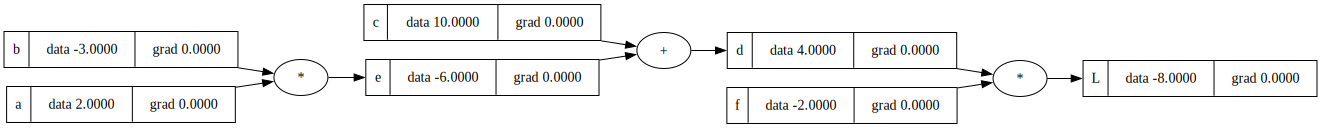

In [1868]:
draw_dot(L)

In [1869]:
L.grad=1.0
f.grad=4.0
d.grad=-2.0
c.grad=-2.0
e.grad=-2.0
a.grad=6.0
b.grad=-4.0

In [1870]:
def lol():
    h=0.00001
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L1=L.data

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    b.data+=h
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e+c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L2=L.data
    print((L2-L1)/h)
lol()

-4.000000000026205


In [1871]:
a.data+=0.01*a.grad
b.data+=0.01*b.grad
c.data+=0.01*c.grad
f.data+=0.01*f.grad
e = a*b
d = e + c
L = d * f 
print(L.data)


-7.286496


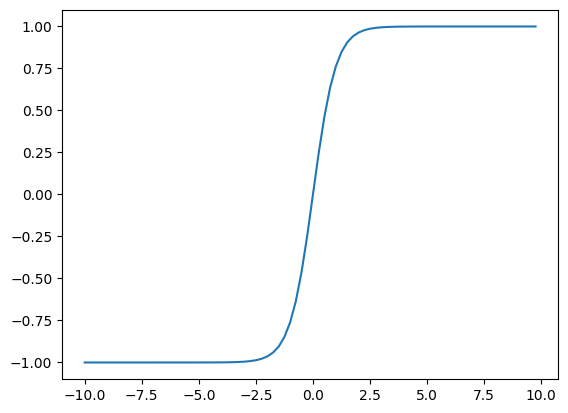

In [1872]:
a=np.arange(-10,10,0.25)
plt.plot(a,np.tanh(a))

In [1873]:
#input values
x1=Value(2.0,label='x1')
x2=Value(0.0,label='x2')
#weights
w1=Value(-3.0,label='w1')
w2=Value(1.0,label='w2')
#bias of the neuron
b=Value(6.8812,label='b')
#x1*w1+x2*w2
x1w1=x1*w1;x1w1.label='x1w1'
x2w2=x2*w2;x2w2.label='x2w2'
x1w1x2w2=x1w1+x2w2;x1w1x2w2.label='x1w1+x2w2'
n=x1w1x2w2+b;n.label='n'
o=n.tanh();o.label='o'



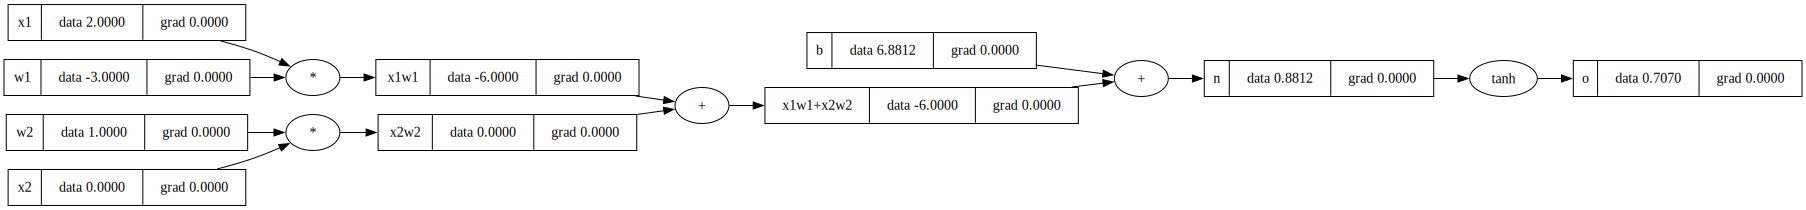

In [1874]:
draw_dot(o)

In [1875]:
o.backward()

In [1876]:
o.grad=1.0

In [1877]:
#o=tanh(n)
#do/dn=1-o**2
n.grad=1-o.data**2

In [1878]:
x1w1x2w2.grad=n.grad
b.grad=n.grad

In [1879]:
x1w1.grad=x1w1x2w2.grad
x2w2.grad=x1w1x2w2.grad

In [1880]:
x2.grad=w2.data*x2w2.grad
w2.grad=x2.data*x2w2.grad

In [1881]:
x1.grad=w1.data*x1w1.grad
w1.grad=x1.data*x1w1.grad

In [1882]:
topo = []
visited = set()
def build_topo(v):
  if v not in visited:
    visited.add(v)
    for child in v._prev:
      build_topo(child)
    topo.append(v)
build_topo(o)
topo

[Value(data=0.0),
 Value(data=1.0),
 Value(data=0.0),
 Value(data=2.0),
 Value(data=-3.0),
 Value(data=-6.0),
 Value(data=-6.0),
 Value(data=6.8812),
 Value(data=0.8811999999999998),
 Value(data=0.707019977022909)]

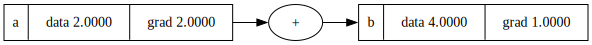

In [1883]:
a=Value(2.0,label='a')
b=a+a;b.label='b'
b.backward()
draw_dot(b)

Lets implement the above in PyTorch :)))

In [1884]:
import torch

In [1885]:
x1=torch.tensor([2.0]).double()          ;x1.requires_grad=True
w1=torch.tensor([-3.0]).double()         ;w1.requires_grad=True 
x2=torch.tensor([0.0]).double()          ;x2.requires_grad=True
w2=torch.tensor([1.0]).double()          ;w2.requires_grad=True
b=torch.tensor([6.8813]).double()        ;b.requires_grad=True
n=x1*w1+x2*w2+b
o=torch.tanh(n)
print(o.data.item())
o.backward()
b=print('x2',x2.grad.item())
print('x1',x1.grad.item())
print('w1',w1.grad.item())
print('w2',w2.grad.item())

0.7070699720278941
x2 0.5000520546564731
x1 -1.5001561639694192
w1 1.0001041093129461
w2 0.0


In [1886]:
o.item()

0.7070699720278941

In [1887]:
class Neuron:
  
  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))
  
  def __call__(self, x):
    # w * x + b
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out
  
  def parameters(self):
    return self.w + [self.b]

class Layer:
  
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]
  
  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs
  
  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
  
  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x
  
  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

In [1888]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=0.8654304128153187)

In [1889]:
a=n.parameters()
a

[Value(data=-0.11545375381711298),
 Value(data=0.16517387389578575),
 Value(data=-0.3052435231023971),
 Value(data=0.259769905227879),
 Value(data=-0.031003028739704064),
 Value(data=0.4082471284570828),
 Value(data=-0.5647796439850281),
 Value(data=-0.035158186475083175),
 Value(data=-0.09967264463370862),
 Value(data=-0.5197998005783608),
 Value(data=-0.22518467070042814),
 Value(data=0.12608288701674675),
 Value(data=0.45762726837271206),
 Value(data=-0.7887121330665638),
 Value(data=0.9509873930528927),
 Value(data=0.7699843536416078),
 Value(data=-0.49008095996677725),
 Value(data=-0.30551472748610276),
 Value(data=-0.40487290722896785),
 Value(data=0.3754136990760124),
 Value(data=-0.17710765528803996),
 Value(data=0.5449367351667815),
 Value(data=-0.20373565195067256),
 Value(data=0.8625891922094808),
 Value(data=-0.1277081479571922),
 Value(data=0.06900168503329795),
 Value(data=-0.6353286858891118),
 Value(data=0.04990593323050385),
 Value(data=-0.8806826156874987),
 Value(dat

In [1890]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets
ypred=[n(x) for x in xs]

In [1891]:
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss

Value(data=4.808270541206026)

In [1892]:
loss.backward()

In [1893]:
n.layers[1].neurons[0].w[0].data

-0.49008095996677725

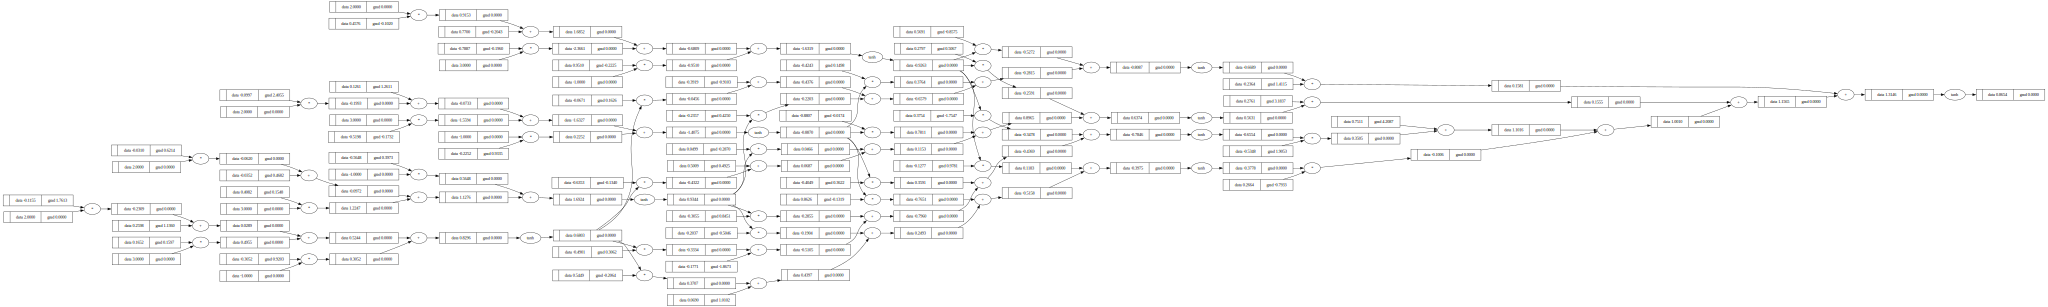

In [1894]:
draw_dot(n(x))

In [1895]:
for k in range(20):
  
  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
  
  # backward pass
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()
  
  # update
  for p in n.parameters():
    p.data += -0.1 * p.grad
  
  print(k, loss.data)

0 4.808270541206026
1 0.45871872328828767
2 0.1952702213593487
3 0.12379929892849963
4 0.09038048578252078
5 0.07077948820264232
6 0.05792879138046683
7 0.04887905350309247
8 0.04217682501500868
9 0.03702332508488908
10 0.03294366125887571
11 0.029638107546701
12 0.0269083606539523
13 0.024618109578612588
14 0.02267064442020983
15 0.02099549877866618
16 0.01954014624361221
17 0.018264655049329788
18 0.017138141987469897
19 0.01613635758941124


In [1896]:
ypred

[Value(data=0.9325450746442109),
 Value(data=-0.9513594111949735),
 Value(data=-0.9200518811606214),
 Value(data=0.9468155845251536)]

In [1897]:
loss

Value(data=0.01613635758941124)